Running Chikungunya simulation...
Basic Reproduction Number (R0): 2.743


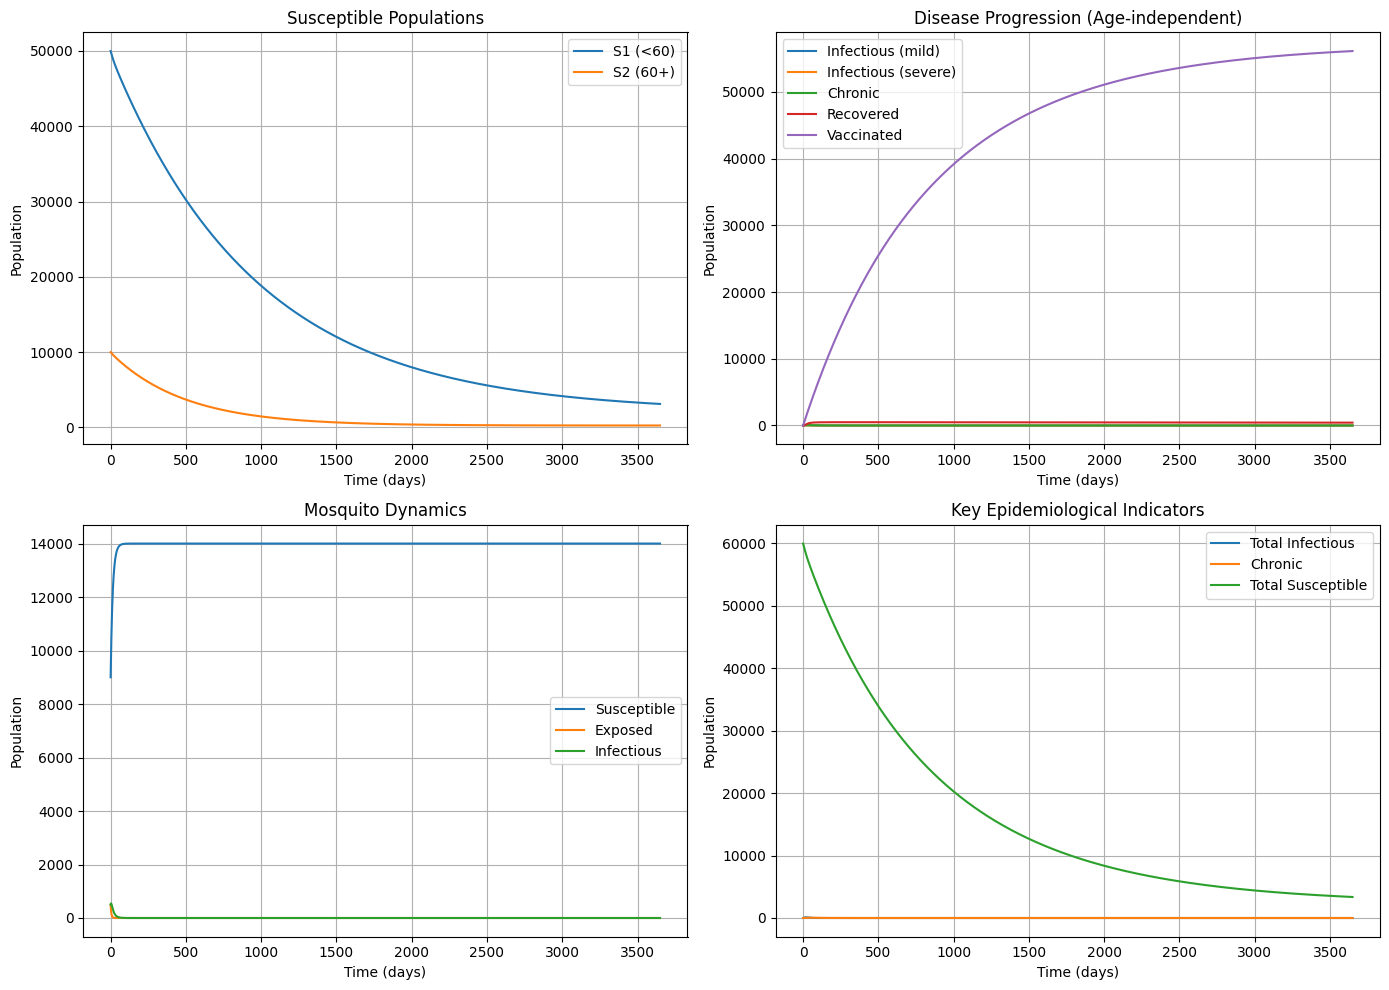


Final Populations:
Total Infectious: -0
Chronic Cases: 0
Recovered: 428
Vaccinated: 56124
Total Mosquitoes: 14000


In [1]:
# -*- coding: utf-8 -*-
"""
CHIKUNGUNYA MODEL - KENYA
--------------------------------
The aim of this model is to predict the next outbreak of Chikungunya virus 
in Kenya and identify high-burden areas for vaccine prioritization.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint


# -----------------------------------------------------------------------------
# MODEL EQUATIONS
# -----------------------------------------------------------------------------
def chikungunya_model(y, t, p):
    # Unpack parameters
    mu, sigma, gamma_m, gamma_s, gamma_c, \
    severe_prob_1, severe_prob_2, chronic_prob_m, chronic_prob_s, \
    vaccination_rate_1, vaccination_rate_2, contact_rate_1, contact_rate_2, \
    prop_age1_Im, prop_age1_Is, prop_age1_C, prop_age1_R, prop_age1_V, \
    Lambda_m, mu_m, sigma_m, b, beta_hm, beta_mh = p.values()
    
    # Unpack state variables
    S1, E1, S2, E2, Im, Is, C, R, V, Sm, Em, Im_mosq = y
    
    # Total human populations
    N1 = S1 + E1 + prop_age1_Im * Im + prop_age1_Is * Is + prop_age1_C * C + prop_age1_R * R + prop_age1_V * V
    N2 = S2 + E2 + (1 - prop_age1_Im) * Im + (1 - prop_age1_Is) * Is + (1 - prop_age1_C) * C + (1 - prop_age1_R) * R + (1 - prop_age1_V) * V
    N_total = N1 + N2
    
    # Total infectious humans
    I_total = Im + Is
    
    # Force of infection
    lambda_h = b * beta_mh * Im_mosq / N_total
    lambda_m = b * beta_hm * I_total / N_total
    
    # Age-specific FOI
    lambda_h1 = lambda_h * contact_rate_1
    lambda_h2 = lambda_h * contact_rate_2
    
    # Differential equations
    dS1 = mu * N1 - mu * S1 - lambda_h1 * S1 - vaccination_rate_1 * S1
    dE1 = lambda_h1 * S1 - (sigma + mu) * E1

    dS2 = mu * N2 - mu * S2 - lambda_h2 * S2 - vaccination_rate_2 * S2
    dE2 = lambda_h2 * S2 - (sigma + mu) * E2
    
    dIm = sigma * (1 - severe_prob_1) * E1 + sigma * (1 - severe_prob_2) * E2 - (gamma_m + mu + chronic_prob_m * gamma_m) * Im
    dIs = sigma * severe_prob_1 * E1 + sigma * severe_prob_2 * E2 - (gamma_s + mu + chronic_prob_s * gamma_s) * Is
    dC = chronic_prob_m * gamma_m * Im + chronic_prob_s * gamma_s * Is - (gamma_c + mu) * C
    dR = (1 - chronic_prob_m) * gamma_m * Im + (1 - chronic_prob_s) * gamma_s * Is + gamma_c * C - mu * R
    dV = vaccination_rate_1 * S1 + vaccination_rate_2 * S2 - mu * V
    
    dSm = Lambda_m - mu_m * Sm - lambda_m * Sm
    dEm = lambda_m * Sm - (sigma_m + mu_m) * Em
    dIm_mosq = sigma_m * Em - mu_m * Im_mosq
    
    return [dS1, dE1, dS2, dE2, dIm, dIs, dC, dR, dV, dSm, dEm, dIm_mosq]


# -----------------------------------------------------------------------------
# SIMULATION FUNCTION
# -----------------------------------------------------------------------------
def run_chikungunya_simulation(params, y0, t):
    sol = odeint(chikungunya_model, y0, t, args=(params,))
    results = pd.DataFrame(sol, columns=["S1","E1","S2","E2","Im","Is","C","R","V","Sm","Em","Im_mosq"])
    results["time"] = t
    return results


# -----------------------------------------------------------------------------
# R0 CALCULATION
# -----------------------------------------------------------------------------
def calculate_R0(params):
    mu, sigma, gamma_m, gamma_s, gamma_c, \
    severe_prob_1, severe_prob_2, chronic_prob_m, chronic_prob_s, \
    vaccination_rate_1, vaccination_rate_2, contact_rate_1, contact_rate_2, \
    prop_age1_Im, prop_age1_Is, prop_age1_C, prop_age1_R, prop_age1_V, \
    Lambda_m, mu_m, sigma_m, b, beta_hm, beta_mh = params.values()

    avg_infectious_period_mild = 1 / (gamma_m + mu)
    avg_infectious_period_severe = 1 / (gamma_s + mu)
    avg_severe_prob = (severe_prob_1 + severe_prob_2) / 2
    avg_infectious_period = (1 - avg_severe_prob) * avg_infectious_period_mild + avg_severe_prob * avg_infectious_period_severe
    avg_infectious_period_mosquito = 1 / mu_m
    prob_transmission = sigma_m / (sigma_m + mu_m)
    
    R0 = (b**2 * beta_hm * beta_mh * prob_transmission * avg_infectious_period * avg_infectious_period_mosquito) / mu_m
    return R0


# -----------------------------------------------------------------------------
# PLOTTING FUNCTION
# -----------------------------------------------------------------------------
def plot_chikungunya_results(df):
    df["Total_Infectious"] = df["Im"] + df["Is"]
    df["Total_Susceptible"] = df["S1"] + df["S2"]
    df["Total_Exposed"] = df["E1"] + df["E2"]
    df["Total_Mosquito"] = df["Sm"] + df["Em"] + df["Im_mosq"]

    fig, axs = plt.subplots(2, 2, figsize=(14,10))
    
    # Plot 1
    axs[0,0].plot(df["time"], df["S1"], label="S1 (<60)")
    axs[0,0].plot(df["time"], df["S2"], label="S2 (60+)")
    axs[0,0].set_title("Susceptible Populations")
    axs[0,0].legend()
    
    # Plot 2
    axs[0,1].plot(df["time"], df["Im"], label="Infectious (mild)")
    axs[0,1].plot(df["time"], df["Is"], label="Infectious (severe)")
    axs[0,1].plot(df["time"], df["C"], label="Chronic")
    axs[0,1].plot(df["time"], df["R"], label="Recovered")
    axs[0,1].plot(df["time"], df["V"], label="Vaccinated")
    axs[0,1].set_title("Disease Progression (Age-independent)")
    axs[0,1].legend()
    
    # Plot 3
    axs[1,0].plot(df["time"], df["Sm"], label="Susceptible")
    axs[1,0].plot(df["time"], df["Em"], label="Exposed")
    axs[1,0].plot(df["time"], df["Im_mosq"], label="Infectious")
    axs[1,0].set_title("Mosquito Dynamics")
    axs[1,0].legend()
    
    # Plot 4
    axs[1,1].plot(df["time"], df["Total_Infectious"], label="Total Infectious")
    axs[1,1].plot(df["time"], df["C"], label="Chronic")
    axs[1,1].plot(df["time"], df["Total_Susceptible"], label="Total Susceptible")
    axs[1,1].set_title("Key Epidemiological Indicators")
    axs[1,1].legend()

    for ax in axs.flat:
        ax.set_xlabel("Time (days)")
        ax.set_ylabel("Population")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------
# MAIN EXECUTION
# -----------------------------------------------------------------------------
def main():
    # Parameters
    params = dict(
        mu = 1/(62*365),
        sigma = 1/5,
        gamma_m = 1/7,
        gamma_s = 1/14,
        gamma_c = 1/60,
        severe_prob_1 = 0.1,
        severe_prob_2 = 0.3,
        chronic_prob_m = 0.15,
        chronic_prob_s = 0.25,
        vaccination_rate_1 = 0.001,
        vaccination_rate_2 = 0.002,
        contact_rate_1 = 1.0,
        contact_rate_2 = 0.8,
        prop_age1_Im = 0.8,
        prop_age1_Is = 0.7,
        prop_age1_C = 0.75,
        prop_age1_R = 0.8,
        prop_age1_V = 0.8,
        Lambda_m = 1000,
        mu_m = 1/14,
        sigma_m = 1/7,
        b = 0.5,
        beta_hm = 0.1,
        beta_mh = 0.1
    )

    # Initial conditions
    y0 = [
        50000 - 10,  # S1
        0,           # E1
        10000 - 5,   # S2
        0,           # E2
        7,           # Im
        8,           # Is
        0,           # C
        0,           # R
        0,           # V
        9000,        # Sm
        500,         # Em
        500          # Im_mosq
    ]

    t = np.arange(0, 365*10, 0.5)

    print("Running Chikungunya simulation...")
    results = run_chikungunya_simulation(params, y0, t)

    R0 = calculate_R0(params)
    print(f"Basic Reproduction Number (R0): {R0:.3f}")

    # Plot results
    plot_chikungunya_results(results)

    # Print summary
    final = results.iloc[-1]
    print("\nFinal Populations:")
    print(f"Total Infectious: {final['Im'] + final['Is']:.0f}")
    print(f"Chronic Cases: {final['C']:.0f}")
    print(f"Recovered: {final['R']:.0f}")
    print(f"Vaccinated: {final['V']:.0f}")
    print(f"Total Mosquitoes: {final['Sm'] + final['Em'] + final['Im_mosq']:.0f}")

    return results, R0


# -----------------------------------------------------------------------------
# RUN SIMULATION
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    results, R0 = main()
